## Random Forests
In this notebook, we use sklearn.ensemble.RandomForestClassifier to predict the status (legendary, sub-legendary, mythical, normal) of pokemon based on their stats.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### 0. Data Prep

In [2]:
df = pd.read_csv("./data/pokedex_enc.csv", index_col=0)

In [3]:
ycols = [c for c in df.columns if "status_" in c]
y = df.loc[:, ycols]
x = df.drop(ycols + ["pokedex_number", "name"], axis=1)
display(y.head())
display(x.head())

,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


,generation,type_number,height_m,weight_kg,abilities_number,total_points,hp,attack,defense,sp_attack,...,species_Wish Pokémon,species_Wolf Pokémon,species_Wood Gecko Pokémon,species_Woodpecker Pokémon,species_Wool Pokémon,species_Woolly Crab Pokémon,species_Worm Pokémon,species_Wrestling Pokémon,species_Young Fowl Pokémon,species_Zen Charm Pokémon
0,1,2,0.7,6.9,2,318.0,45.0,49.0,49.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,1.0,13.0,2,405.0,60.0,62.0,63.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2.0,100.0,2,525.0,80.0,82.0,83.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,2.4,155.5,1,625.0,80.0,100.0,123.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0.6,8.5,2,309.0,39.0,52.0,43.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, shuffle=True)

### 1. Base Model

In this section we create a simple preliminary model to establish a quick baseline.

In [5]:
%%time
clf_base = RandomForestClassifier()
clf_base.fit(x_train, y_train)

Wall time: 148 ms


RandomForestClassifier()

In [6]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score

In [7]:
def getAccuracy(y_true, y_pred, names, verbose=True):
    confusion = confusion_matrix(y_true.values.argmax(axis=1), y_pred.argmax(axis=1))
    accuracy = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted')
    f1_u = f1_score(y_true, y_pred, average='macro')
    if verbose:
        print(ycols)
        print(confusion_matrix(y_true.values.argmax(axis=1), y_pred.argmax(axis=1)))
        print(f"accuracy:\t\t{accuracy}\nroc:\t\t\t{roc}\nf1 (weighted):\t\t{f1_w}\nf1 (unweighted):\t{f1_u}")
    return {"accuracy": accuracy, "roc": roc, "f1_w": f1_w, "f1_u": f1_u, "confusion": confusion}

In [8]:
y_pred = clf_base.predict(x_valid)
base_acc = getAccuracy(y_valid, y_pred, ycols)

['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  4   1   0   0]
 [  0   0 137   0]
 [  3   0   0   3]]
accuracy:		0.948051948051948
roc:			0.8166666666666667
f1 (weighted):		0.9618260527351437
f1 (unweighted):	0.7272727272727272


### 2. Hyperparameter Tuning

This section will investigate notable hyperparameters to find optimal settings. Unfortunately due to a relatively small dataset, evaluations will vary from run to run. Hyperparameters are picked based on data from multiple runthroughs of the notebook, as well as best judgement to avoid overfitting. 

#### n_estimators

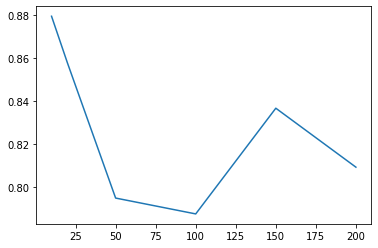

In [9]:
res = []
params = [10, 20, 50, 100, 150, 200]
for n_est in params:
    clf = RandomForestClassifier(n_estimators=n_est)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

#### max_depth

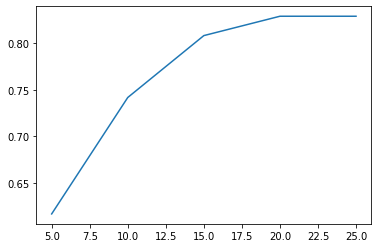

In [10]:
res = []
params = [5, 10, 15, 20, 25, None]
for max_depth in params:
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

#### min_samples_leaf

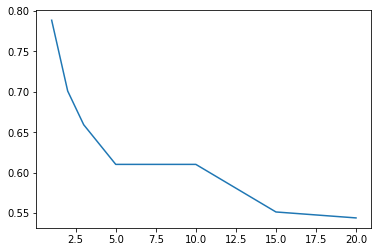

In [11]:
res = []
params = [1, 2, 3, 5, 10, 15, 20]
for min_leaf in params:
    clf = RandomForestClassifier(min_samples_leaf=min_leaf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

#### max_features

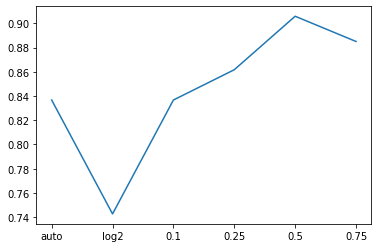

In [12]:
res = []
params = ["auto", "log2", 0.1, 0.25, 0.5, 0.75]
for max_feat in params:
    clf = RandomForestClassifier(max_features=max_feat)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

### 3. Augmented Model

Here we improve the base model by using the tuned hyperparameters and compare accuracy on the validation set.

In [13]:
clf_aug = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=0.5)
clf_aug.fit(x_train, y_train)
y_pred = clf_aug.predict(x_valid)
aug_acc = getAccuracy(y_valid, y_pred, ycols, verbose=False)
print(f"{aug_acc}\n{base_acc}")

{'accuracy': 0.9675324675324676, 'roc': 0.8849662162162162, 'f1_w': 0.9724025974025974, 'f1_u': 0.8124999999999999, 'confusion': array([[  5,   0,   0,   1],
       [  1,   3,   0,   1],
       [  0,   0, 137,   0],
       [  2,   0,   0,   4]], dtype=int64)}
{'accuracy': 0.948051948051948, 'roc': 0.8166666666666667, 'f1_w': 0.9618260527351437, 'f1_u': 0.7272727272727272, 'confusion': array([[  6,   0,   0,   0],
       [  4,   1,   0,   0],
       [  0,   0, 137,   0],
       [  3,   0,   0,   3]], dtype=int64)}


### 4. Feature Selection

We have a very large amount of features available to the model. We use feature importance to select the most relevant features from our input data to reduce complexity, noise, and overfitting in our model.

<AxesSubplot:xlabel='feature'>

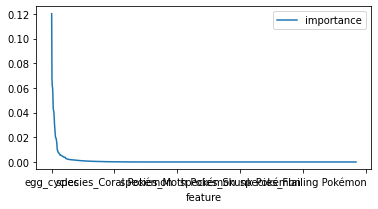

In [14]:
base_importances = pd.DataFrame({"feature": x_train.columns, "importance": clf_base.feature_importances_})
base_importances.sort_values(by=["importance"], ascending=False).plot("feature", "importance", figsize=(6, 3))

In [15]:
print(base_importances.sort_values(by=["importance"], ascending=False).iloc[:50, :])

                         feature  importance
18                    egg_cycles    0.120097
14               base_experience    0.067304
12                    catch_rate    0.061528
17               percentage_male    0.059940
325        egg_type_Undiscovered    0.053129
2                       height_m    0.042874
13               base_friendship    0.042138
5                   total_points    0.040127
15                   growth_rate    0.036634
3                      weight_kg    0.030840
6                             hp    0.027623
9                      sp_attack    0.024341
7                         attack    0.020385
10                    sp_defense    0.019475
11                         speed    0.019329
8                        defense    0.017910
4               abilities_number    0.015932
0                     generation    0.012244
27                against_ground    0.009648
70           ability_Beast Boost    0.009545
24                   against_ice    0.008173
25        

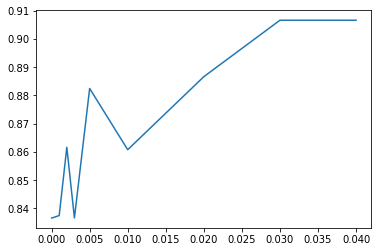

In [16]:
res = []
params = [1e-5, 1e-4, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04]
for cutoff in params:
    trimmed_x_train = x_train.drop(base_importances[base_importances["importance"] < cutoff]["feature"], axis=1)
    trimmed_x_valid = x_valid.drop(base_importances[base_importances["importance"] < cutoff]["feature"], axis=1)
    clf = RandomForestClassifier(n_estimators=150, max_depth=15)
    clf.fit(trimmed_x_train, y_train)
    y_pred = clf.predict(trimmed_x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

In [17]:
trimmed_x_train = x_train.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)
trimmed_x_valid = x_valid.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)
clf_trimmed = RandomForestClassifier(n_estimators=150, max_depth=15)
clf_trimmed.fit(trimmed_x_train, y_train)
y_pred = clf_trimmed.predict(trimmed_x_valid)
trimmed_acc = getAccuracy(y_valid, y_pred, ycols, verbose=False)
print(f"{trimmed_acc}\n{aug_acc}\n{base_acc}")

{'accuracy': 0.9675324675324676, 'roc': 0.8816441441441442, 'f1_w': 0.9730983302411874, 'f1_u': 0.8095238095238096, 'confusion': array([[  5,   0,   0,   1],
       [  3,   2,   0,   0],
       [  0,   0, 137,   0],
       [  1,   0,   0,   5]], dtype=int64)}
{'accuracy': 0.9675324675324676, 'roc': 0.8849662162162162, 'f1_w': 0.9724025974025974, 'f1_u': 0.8124999999999999, 'confusion': array([[  5,   0,   0,   1],
       [  1,   3,   0,   1],
       [  0,   0, 137,   0],
       [  2,   0,   0,   4]], dtype=int64)}
{'accuracy': 0.948051948051948, 'roc': 0.8166666666666667, 'f1_w': 0.9618260527351437, 'f1_u': 0.7272727272727272, 'confusion': array([[  6,   0,   0,   0],
       [  4,   1,   0,   0],
       [  0,   0, 137,   0],
       [  3,   0,   0,   3]], dtype=int64)}


### 5. Evaluating the Model
We evaluate all 3 models (base, augmented, trimmed) on the unseen test set to make sure we haven't overfit on the test or validation sets. 

In [18]:
getAccuracy(y_test, clf_base.predict(x_test), ycols, verbose=True)
getAccuracy(y_test, clf_aug.predict(x_test), ycols, verbose=True)
getAccuracy(y_test, 
            clf_trimmed.predict(x_test.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)), 
            ycols, verbose=True)

['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  1   3   0   0]
 [  0   0 138   0]
 [  2   0   0   5]]
accuracy:		0.9741935483870968
roc:			0.912202380952381
f1 (weighted):		0.9852674207512918
f1 (unweighted):	0.8998917748917747
['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  5   0   0   1]
 [  0   4   0   0]
 [  0   0 138   0]
 [  0   0   0   7]]
accuracy:		0.9935483870967742
roc:			0.9783220720720721
f1 (weighted):		0.9934701857282501
f1 (unweighted):	0.9606060606060607
['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  5   0   0   1]
 [  0   4   0   0]
 [  0   0 138   0]
 [  0   0   0   7]]
accuracy:		0.9935483870967742
roc:			0.9783220720720721
f1 (weighted):		0.9934701857282501
f1 (unweighted):	0.9606060606060607


{'accuracy': 0.9935483870967742,
 'roc': 0.9783220720720721,
 'f1_w': 0.9934701857282501,
 'f1_u': 0.9606060606060607,
 'confusion': array([[  5,   0,   0,   1],
        [  0,   4,   0,   0],
        [  0,   0, 138,   0],
        [  0,   0,   0,   7]], dtype=int64)}